# Import Library

In [ ]:
pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import optuna
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import pickle
import seaborn as sns
from sklearn.metrics import f1_score, make_scorer

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Reference/Data Science/Fundamental/Qarir Generator/Material/WAA/Job Priority Project/predictive_maintenance.csv')

In [ ]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [ ]:
data.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


# Data Preprocessing

## EDA

### Count the number of sample

In [ ]:
fig = px.bar(data['Target'].value_counts(),
             title="Target Value Counts",)

fig.show()

In [ ]:
fig = px.bar(data['Failure Type'].value_counts(),
             title="Failure Type Value Counts",)

fig.show()

### Stratified train-test split

In [ ]:
train, test = train_test_split(data,test_size=0.2,stratify=data['Target'],random_state=42)

In [ ]:
train.shape

(8000, 10)

In [ ]:
test.shape

(2000, 10)

### Describe **Data**

In [ ]:
train.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5002.947250,300.005450,310.006062,1539.356875,40.003363,107.685000,0.033875
std,2889.706081,1.996844,1.479432,180.982943,10.019546,63.612002,0.180919
min,1.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2502.750000,298.300000,308.800000,1422.000000,33.200000,53.000000,0.000000
50%,5003.500000,300.100000,310.100000,1503.000000,40.100000,107.000000,0.000000
75%,7509.250000,301.500000,311.100000,1613.000000,46.800000,163.000000,0.000000
max,10000.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


### Check and remove duplicates

In [ ]:
train.duplicated().sum()

0

### Check and fill missing values

In [ ]:
train.isna().sum()

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


### Univariate analysis

#### Check constant value/variance

In [ ]:
numeric_cols = train.select_dtypes(include='number')
constant_columns = numeric_cols.columns[numeric_cols.var() == 0].tolist()
print("Constant numeric columns (variance == 0):", constant_columns)

Constant numeric columns (variance == 0): []


#### Distribution of numerical variables

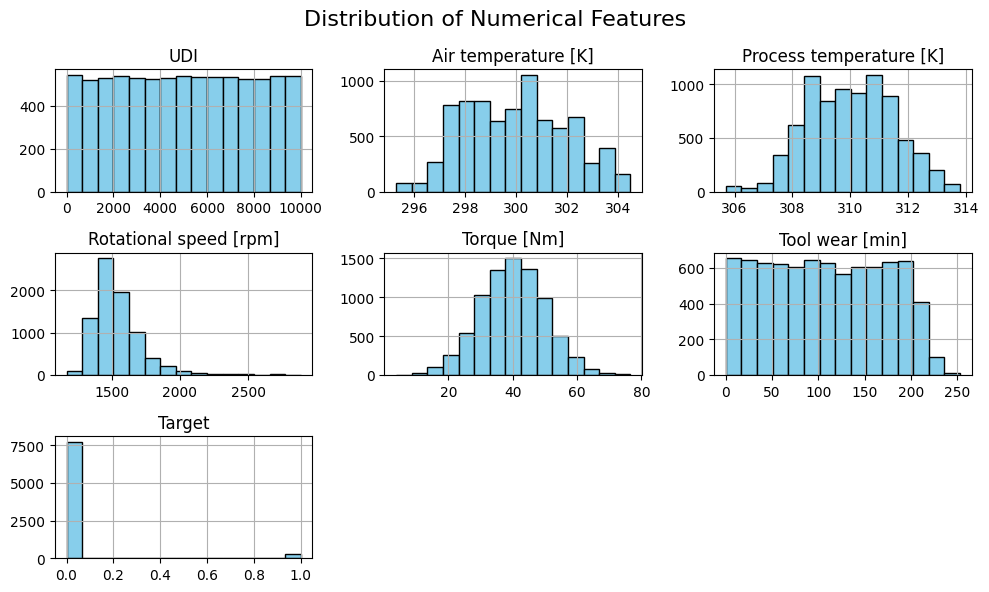

In [ ]:
train.hist(bins=15, figsize=(10, 6), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

#### Counter bar chart for target values

<ipython-input-285-1dc3af214d13>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




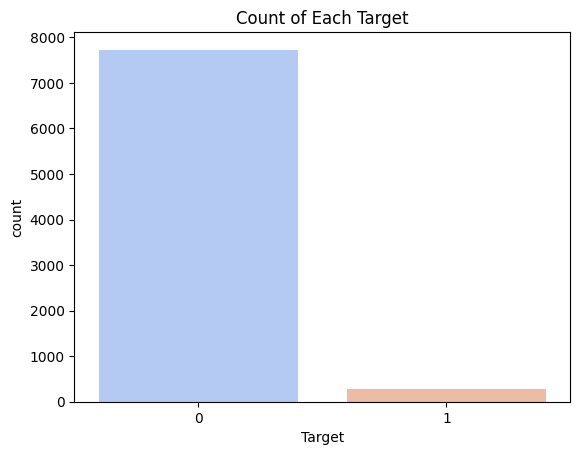

In [ ]:
# Countplot for categorical target
sns.countplot(data=train, x='Target', palette='coolwarm')
plt.title("Count of Each Target")
plt.show()

#### Counter bar chart for categorical values

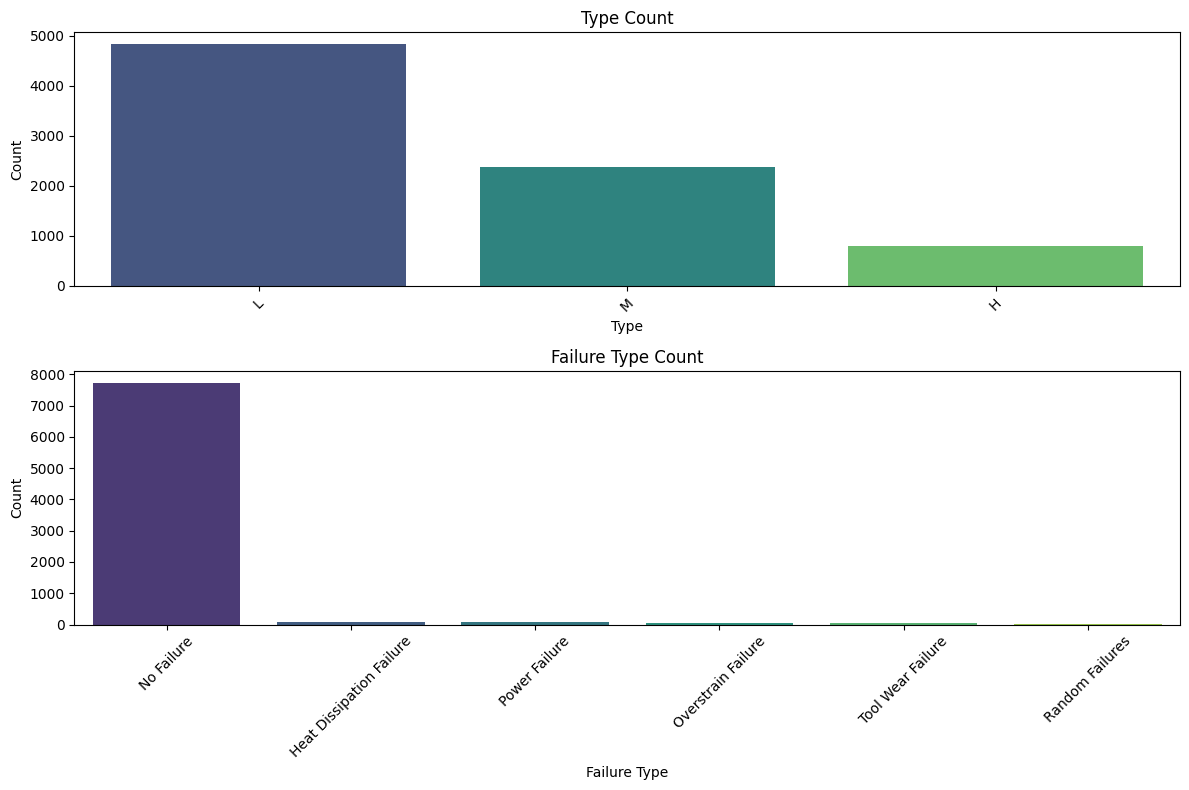

In [ ]:
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols[categorical_cols != 'Product ID']  # Hapus "Product ID"

plt.figure(figsize=(12, len(categorical_cols) * 4))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    counts = train[col].value_counts().reset_index()
    counts.columns = [col, 'Count']

    sns.barplot(data=counts, x=col, y='Count', hue=col, palette='viridis', legend=False)
    plt.title(f"{col} Count")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Bivariate Analysis

#### Pairplot for numerical variables

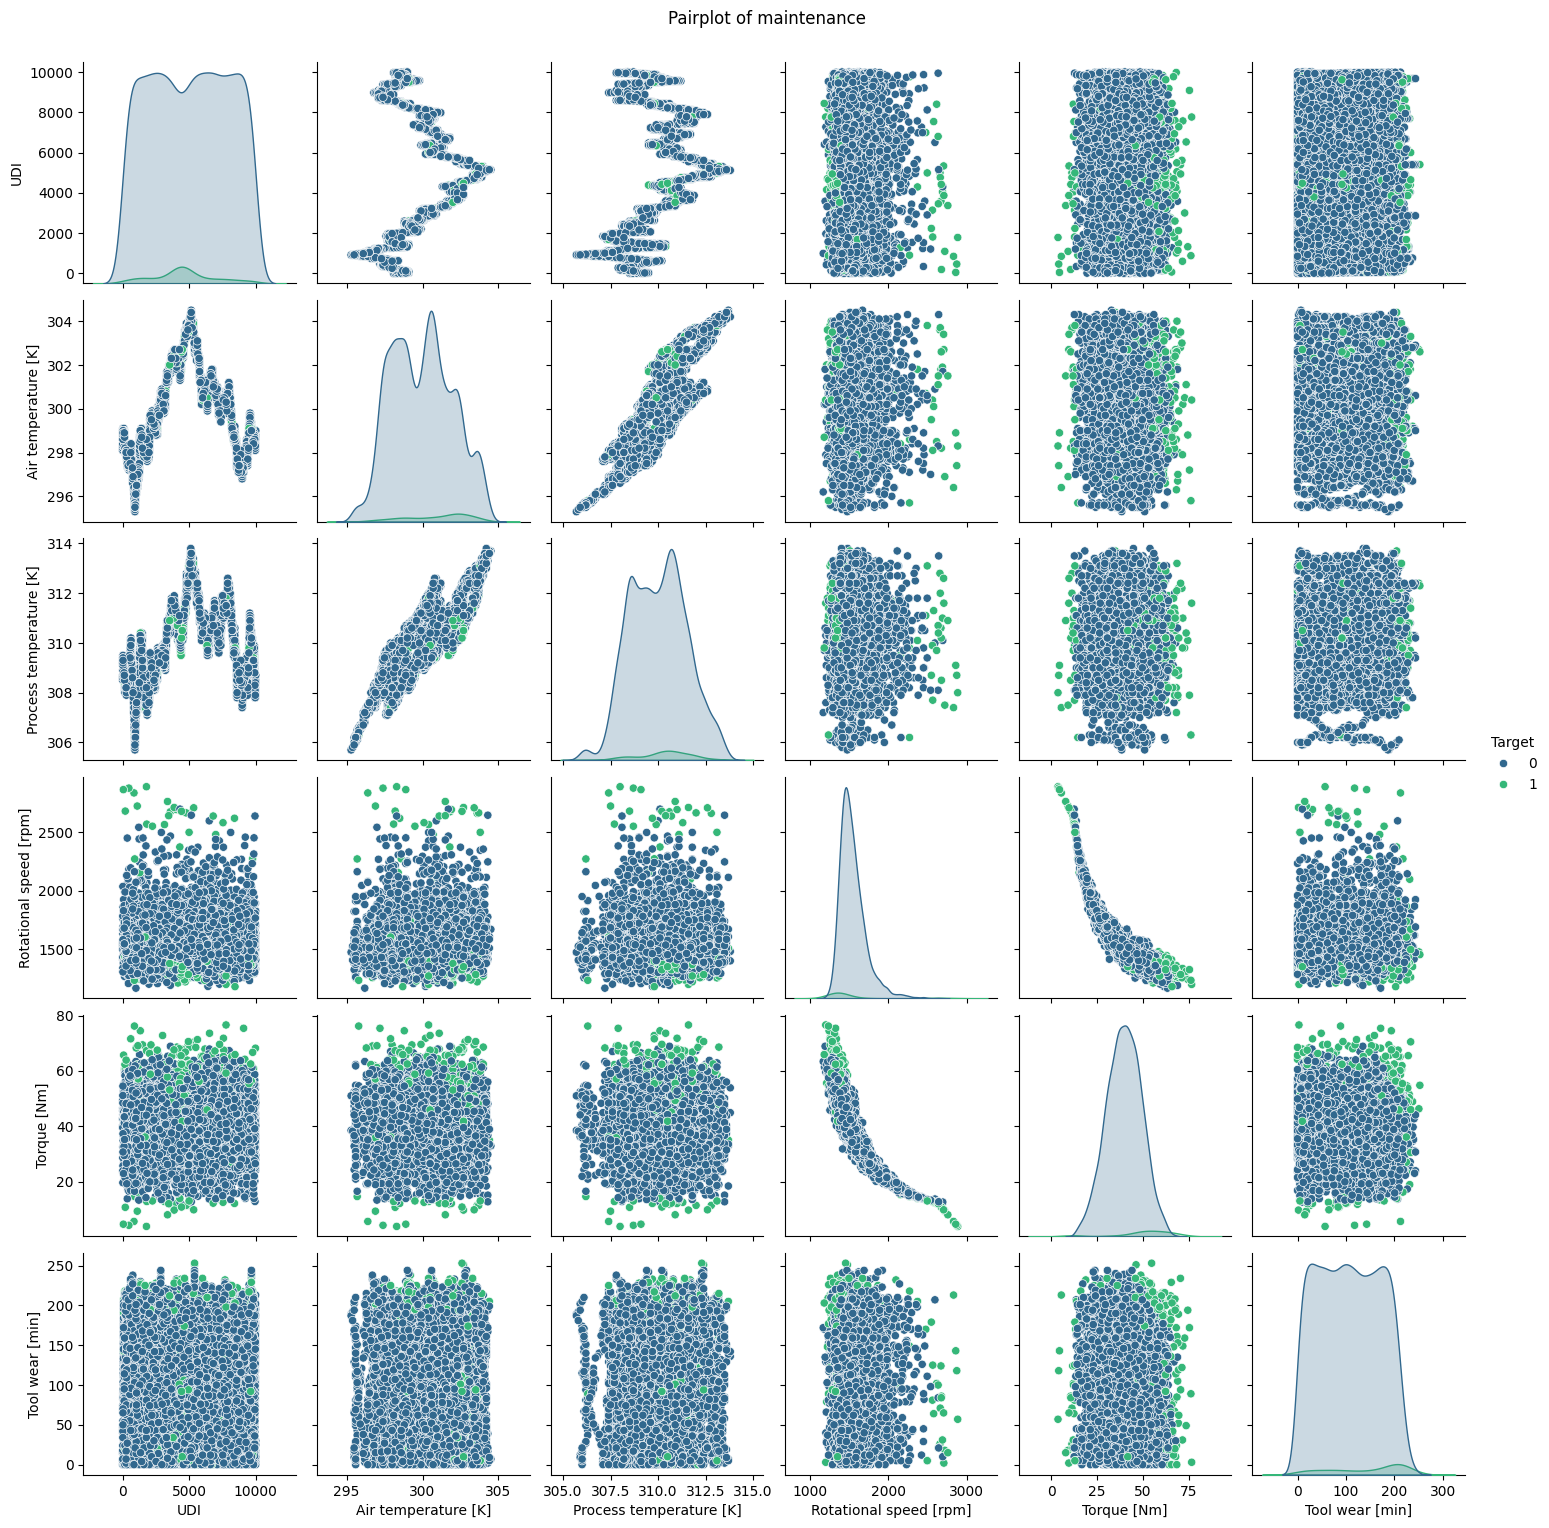

In [ ]:
g = sns.pairplot(train, hue="Target", palette="viridis")
plt.suptitle("Pairplot of maintenance", y=1.02)
g._legend.set_title("Target")
plt.show()

#### Correlation matrix

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 4058 to 1424
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      8000 non-null   int64  
 1   Product ID               8000 non-null   object 
 2   Type                     8000 non-null   object 
 3   Air temperature [K]      8000 non-null   float64
 4   Process temperature [K]  8000 non-null   float64
 5   Rotational speed [rpm]   8000 non-null   int64  
 6   Torque [Nm]              8000 non-null   float64
 7   Tool wear [min]          8000 non-null   int64  
 8   Target                   8000 non-null   int64  
 9   Failure Type             8000 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 687.5+ KB


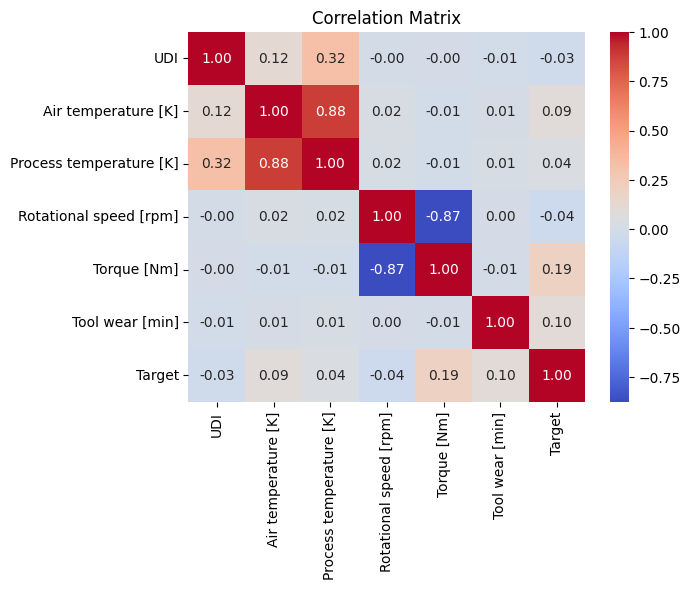

In [ ]:
numeric_train = train.select_dtypes(include=[np.number])
corr_matrix = numeric_train.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Boxplot: Feature distribution by target

<ipython-input-290-9b44cbbef2b6>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




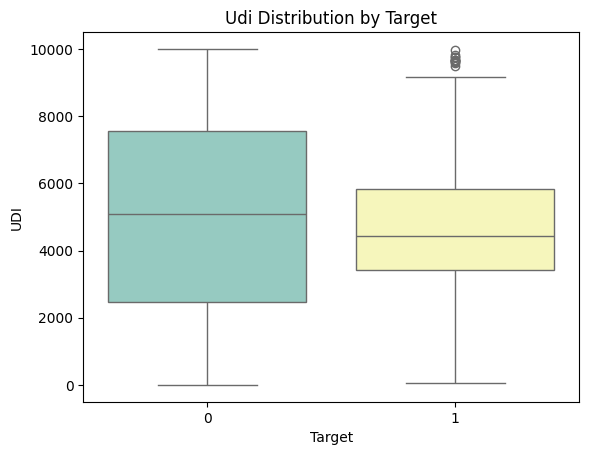

<ipython-input-290-9b44cbbef2b6>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




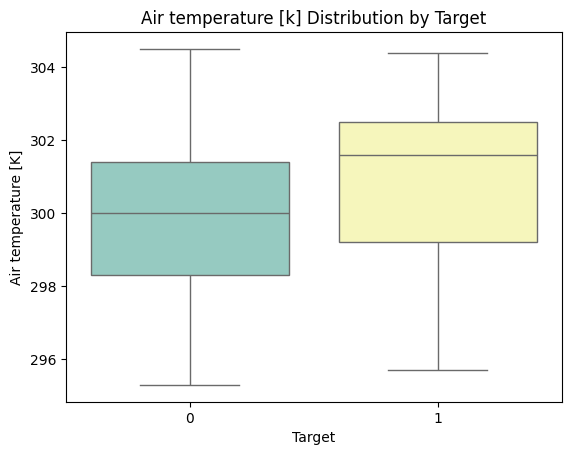

<ipython-input-290-9b44cbbef2b6>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




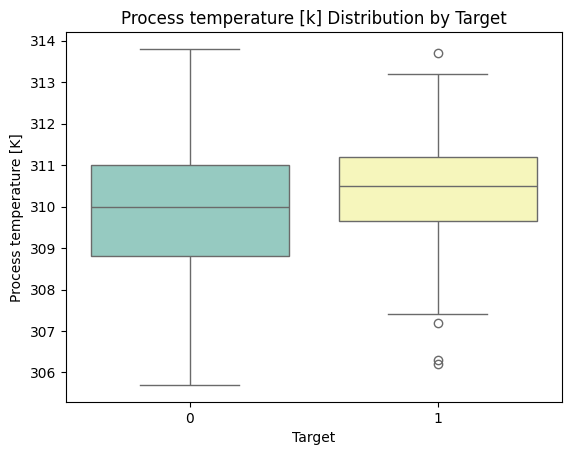

<ipython-input-290-9b44cbbef2b6>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




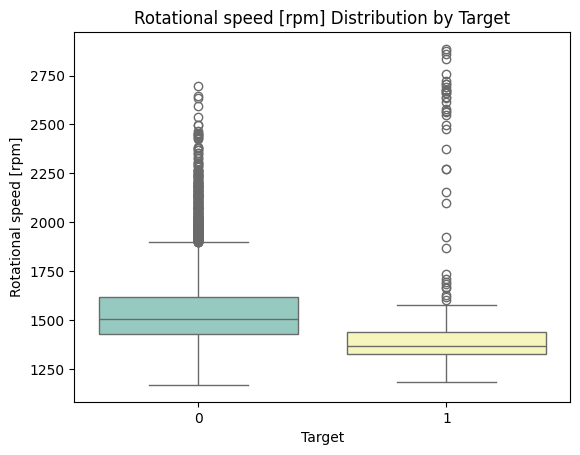

<ipython-input-290-9b44cbbef2b6>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




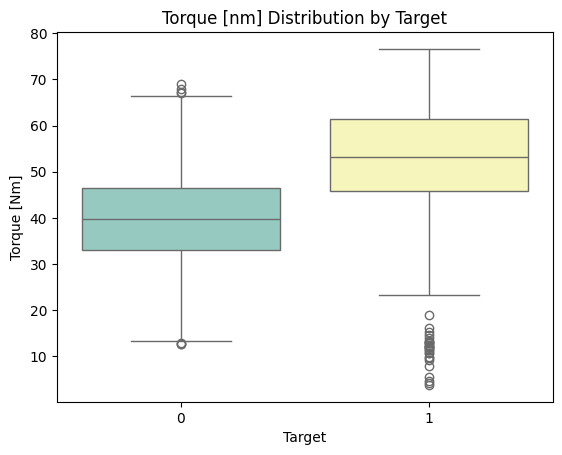

<ipython-input-290-9b44cbbef2b6>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




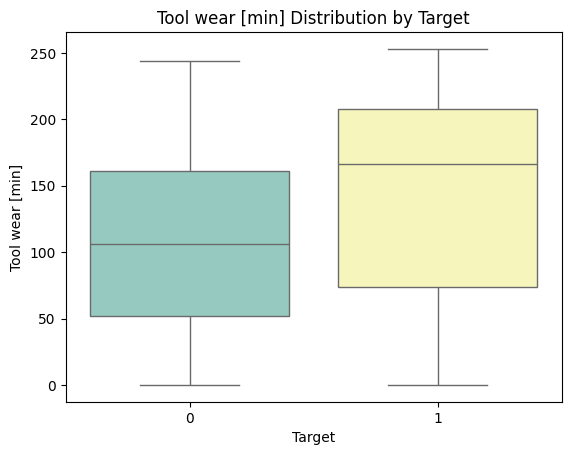

<ipython-input-290-9b44cbbef2b6>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




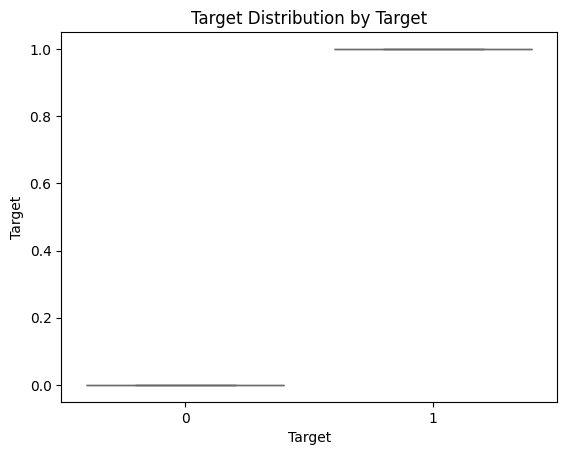

In [ ]:
for feature in numeric_train.columns:
    sns.boxplot(data=train, x='Target', y=feature, palette="Set3")
    plt.title(f"{feature.capitalize()} Distribution by Target")
    plt.show()

## Encoding

In [ ]:
train.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
4058,4059,M18918,M,302.0,310.9,1456,47.2,54,0,No Failure
1221,1222,M16081,M,297.0,308.3,1399,46.4,132,0,Random Failures
6895,6896,M21755,M,301.0,311.6,1357,45.6,137,0,No Failure
9863,9864,L57043,L,298.9,309.8,1411,56.3,84,0,No Failure
8711,8712,L55891,L,297.1,308.5,1733,28.7,50,0,No Failure


### Encode data

In [ ]:
le_type = LabelEncoder()
le_failure = LabelEncoder()

# Fit and transform on train data
train['Type'] = le_type.fit_transform(train['Type'])
train['Failure Type'] = le_failure.fit_transform(train['Failure Type'])

# Transform test data using the same encoders
test['Type'] = le_type.transform(test['Type'])
test['Failure Type'] = le_failure.transform(test['Failure Type'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 4058 to 1424
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      8000 non-null   int64  
 1   Product ID               8000 non-null   object 
 2   Type                     8000 non-null   int64  
 3   Air temperature [K]      8000 non-null   float64
 4   Process temperature [K]  8000 non-null   float64
 5   Rotational speed [rpm]   8000 non-null   int64  
 6   Torque [Nm]              8000 non-null   float64
 7   Tool wear [min]          8000 non-null   int64  
 8   Target                   8000 non-null   int64  
 9   Failure Type             8000 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 687.5+ KB


# Feature engineering

## Feature selection for binary classification

In [ ]:
featurecek = train.drop(columns=['Product ID'])

In [ ]:
# Cek Urutan korelasi terendah ke tertinggi
correlation = featurecek.corr()["Target"].sort_values()
correlation

,Target
Rotational speed [rpm],-0.039966
UDI,-0.026264
Type,-0.013802
Process temperature [K],0.040849
Air temperature [K],0.086001
Tool wear [min],0.099214
Torque [Nm],0.190034
Failure Type,0.496158
Target,1.000000


Features seperti Process temperature, Air temperature,Tool wear, Torque, Failure Type dan Target adalah fiture  yg berkorelasi positive.

Vaeriable dependent yg saling berkorelasi bisa pilih salah satu dan karena fiturnya sedikit jadi kita bisa masukan semua sbg feature selection dan takeout UID dan failur type

# Model Building and Evaluation

In [ ]:
X_train = train.drop(columns=['Product ID','Target','Failure Type','UDI'])
y_train = train['Target']
X_test = test.drop(columns=['Product ID','Target','Failure Type','UDI'])
y_test = test['Target']

In [ ]:
X_train.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
4058,2,302.0,310.9,1456,47.2,54
1221,2,297.0,308.3,1399,46.4,132
6895,2,301.0,311.6,1357,45.6,137
9863,1,298.9,309.8,1411,56.3,84
8711,1,297.1,308.5,1733,28.7,50


In [ ]:
X_train.rename(columns={
    'Rotational speed [rpm]': 'Rotational_speed',
    'Torque [Nm]': 'Torque',
    'Tool wear [min]': 'Tool_wear',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]':'Process temperature'
},inplace=True)
X_test.rename(columns={
    'Rotational speed [rpm]': 'Rotational_speed',
    'Torque [Nm]': 'Torque',
    'Tool wear [min]': 'Tool_wear',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]':'Process temperature'},inplace=True)

In [ ]:
X_train

,Type,Air_temperature,Process temperature,Rotational_speed,Torque,Tool_wear
4058,2,302.0,310.9,1456,47.2,54
1221,2,297.0,308.3,1399,46.4,132
6895,2,301.0,311.6,1357,45.6,137
9863,1,298.9,309.8,1411,56.3,84
8711,1,297.1,308.5,1733,28.7,50
...,...,...,...,...,...,...
980,1,296.1,306.7,1409,42.8,134
4266,1,302.7,311.1,1440,39.5,146
7772,0,300.3,311.5,1464,41.0,29
5780,1,301.7,311.2,1517,42.4,113


## Modeling

In [ ]:
# Define models
models = {
    "XGBoost": XGBClassifier(),
    "LGBM": LGBMClassifier(),
    "GBM": GradientBoostingClassifier(),
}

# Store evaluation results
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results[name] = {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "AUC-ROC": auc
    }

    print(f"{name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, AUC-ROC: {auc:.4f}\n")

# Find the best model based on F1-score
best_model_name = max(results, key=lambda k: results[k]["F1-score"])
best_model = models[best_model_name]

print(f"Best model: {best_model_name} with Precision: {results[best_model_name]['Precision']:.4f}, "
      f"Recall: {results[best_model_name]['Recall']:.4f}, F1-score: {results[best_model_name]['F1-score']:.4f}, "
      f"AUC-ROC: {results[best_model_name]['AUC-ROC']:.4f}")

Training XGBoost...
XGBoost - Precision: 0.8909, Recall: 0.7206, F1-score: 0.7967, AUC-ROC: 0.9662

Training LGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 271, number of negative: 7729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350616
[LightGBM] [Info] Start training from score -3.350616
LGBM - Precision: 0.8909, Recall: 0.7206, F1-score: 0.7967, AUC-ROC: 0.9798

Training GBM...
GBM - Precision: 0.8333, Recall: 0.6618, F1-score: 0.7377, AUC-ROC: 0.9682

Best model: XGBoost with Precision: 0.8909, Recall: 0.7206, F1-score: 0.7967, AUC-ROC: 0.9662


# Hyperparameter Tuning on the Best Model

## Optuna

In [ ]:
count_class_0, count_class_1 = np.bincount(y_train)  # y_train adalah target data latih
scale_pos_weight = count_class_0 / count_class_1
def objective(trial):
    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        # "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "scale_pos_weight": scale_pos_weight # digunakan untuk menangani ketidakseimbangan kelas (imbalanced data)
    }
    model = best_model.__class__(**params)  # Initialize model with new params
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Get the best parameters
best_params = study.best_params
print("Optimized Hyperparameters:", best_params)

[I 2025-03-14 15:48:35,582] A new study created in memory with name: no-name-de799f5c-b111-481b-a90a-35b9dc803766
<ipython-input-301-88c92802715c>:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-301-88c92802715c>:10: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-301-88c92802715c>:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-14 15:48:36,360] Trial 0 finished with value: 0.7703703703703704 and parameters: {'learning_rate': 0.1343235367175824, 'n_estimators': 650, 'max

Optimized Hyperparameters: {'learning_rate': 0.08977723815255656, 'n_estimators': 450, 'max_depth': 12, 'reg_alpha': 6.85062328330899e-05, 'reg_lambda': 3.878003679270244}


## Train Final Model with Optimized Parameters

In [ ]:
# Train the best model with the optimized hyperparameters
final_model = best_model.__class__(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

### Final Model Evaluation

#### Feature Importance


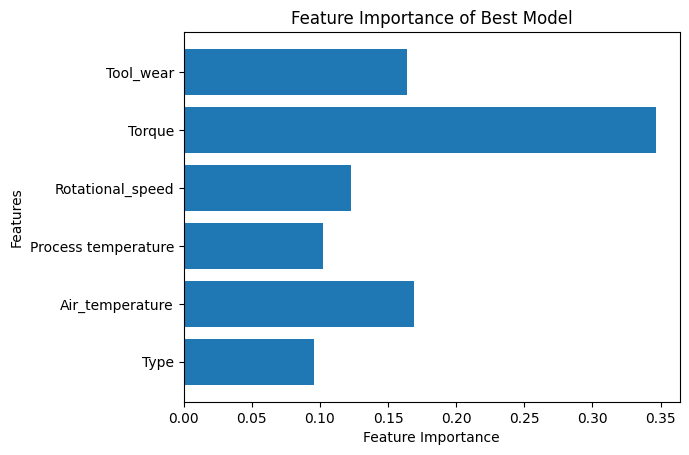

In [ ]:
importances = final_model.feature_importances_
plt.barh(X_train.columns, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance of Best Model")
plt.show()


#### Confusion Matrix

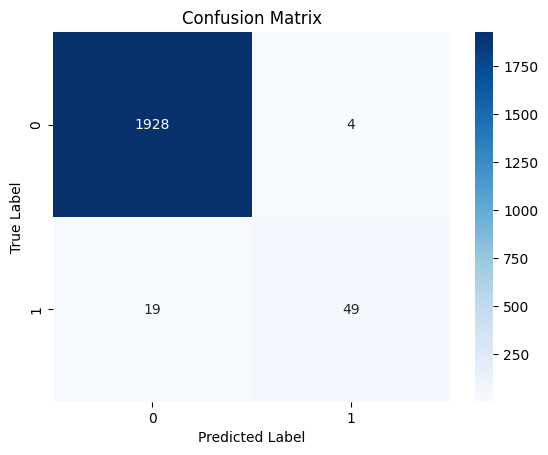

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### AUC-ROC Curve

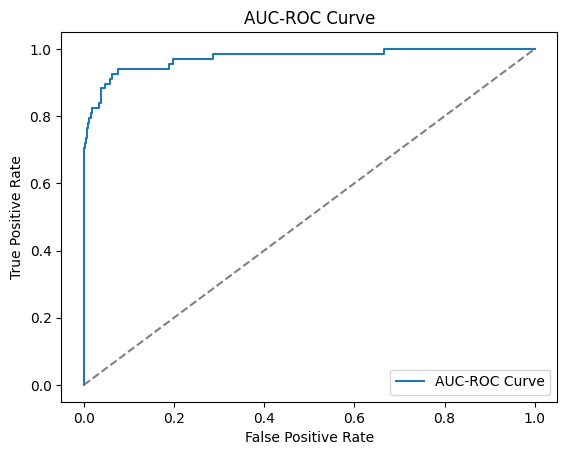

Final Model - precision_score: 0.9245283018867925
Final Model - recall_score: 0.7205882352941176
Final Model - F1-score: 0.8099173553719008
Final Model - AUC-ROC Score: 0.9731381683108026


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="AUC-ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("AUC-ROC Curve")
plt.show()

print("Final Model - precision_score:", precision_score(y_test, y_pred))
print("Final Model - recall_score:", recall_score(y_test, y_pred))
print("Final Model - F1-score:", f1_score(y_test, y_pred))
print("Final Model - AUC-ROC Score:", roc_auc_score(y_test, y_prob))

In [ ]:
# Save the model
with open("maintenancemodel.pkl", "wb") as file:
    pickle.dump(final_model, file)

# Load the model later
with open("maintenancemodel.pkl", "rb") as file:
    loaded_model = pickle.load(file)

## RandomizedSearchCV

In [ ]:
param_dist = {
    "learning_rate": np.logspace(-2, np.log10(0.3), 10),
    "n_estimators": np.arange(100, 1001, 50),
    "max_depth": np.arange(3, 16, 2),
    # "subsample": np.linspace(0.5, 1.0, 5),
    # "colsample_bytree": np.linspace(0.5, 1.0, 5),
    "reg_alpha": np.logspace(-8, 1, 10),
    "reg_lambda": np.logspace(-8, 1, 10),
    "scale_pos_weight": np.linspace(scale_pos_weight * 0.8, scale_pos_weight * 1.2, 5)  # Variasi sekitar nilai asli
}


model = best_model.__class__()

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring=make_scorer(f1_score),
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)


random_search.fit(X_train, y_train)

# Dapatkan parameter terbaik
best_params = random_search.best_params_
print("Optimized Hyperparameters:", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimized Hyperparameters: {'scale_pos_weight': 34.224354243542436, 'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 900, 'max_depth': 13, 'learning_rate': 0.045341755991148446}


## Train Final Model with Optimized Parameters

### Final Model Evaluation

In [ ]:
# Train the best model with the optimized hyperparameters
final_model = best_model.__class__(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

#### Feature Importance

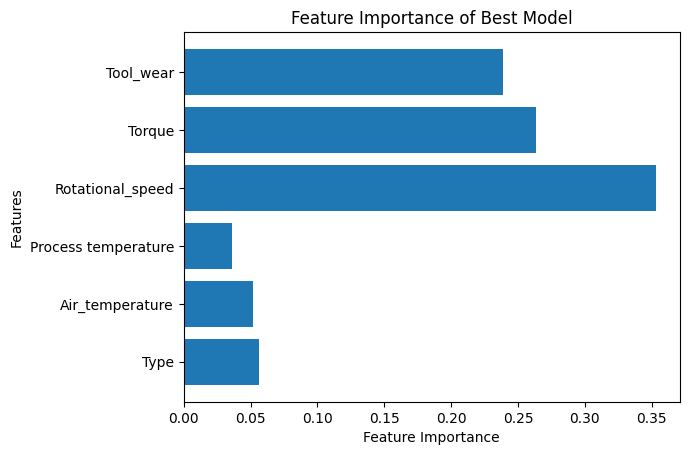

In [ ]:
importances = final_model.feature_importances_
plt.barh(X_train.columns, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance of Best Model")
plt.show()

#### Confusion Matrix

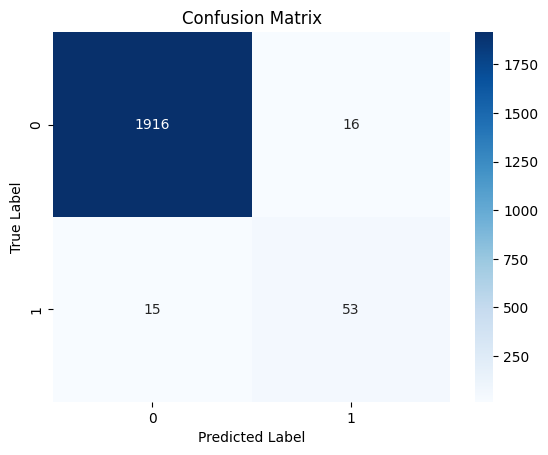

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### AUC-ROC Curve

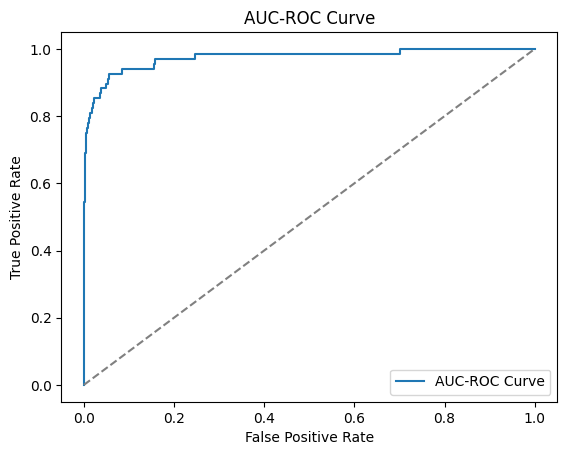

Final Model - precision_score: 0.7681159420289855
Final Model - recall_score: 0.7794117647058824
Final Model - F1-score: 0.7737226277372263
Final Model - AUC-ROC Score: 0.9746148459383753


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="AUC-ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("AUC-ROC Curve")
plt.show()

print("Final Model - precision_score:", precision_score(y_test, y_pred))
print("Final Model - recall_score:", recall_score(y_test, y_pred))
print("Final Model - F1-score:", f1_score(y_test, y_pred))
print("Final Model - AUC-ROC Score:", roc_auc_score(y_test, y_prob))